In [1]:
!pip install pmdarima
# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

In [2]:
df=pd.read_csv("AMZN BP DATA.csv")

In [ ]:
df = df.iloc[:-62, :]

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
0,01-04-2014,16.904499,17.221500,16.900000,17.1495,72002000.0,3.0,NaN,3658.399902
1,02-04-2014,17.299500,17.415001,17.018999,17.0980,89510000.0,4.0,-0.0515,3665.989990
2,03-04-2014,17.091000,17.125000,16.423000,16.6810,127986000.0,5.0,-0.4170,3637.580078
3,04-04-2014,16.757500,16.771999,15.780500,16.1500,250692000.0,6.0,-0.5310,3539.379883
4,07-04-2014,16.049500,16.247000,15.656500,15.8880,141548000.0,2.0,-0.2620,3507.750000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2205 non-null   object 
 1   Open             2205 non-null   float64
 2   High             2205 non-null   float64
 3   Low              2205 non-null   float64
 4   Close            2205 non-null   float64
 5   Volume           2205 non-null   float64
 6   Day of the week  2205 non-null   float64
 7   Change           2204 non-null   float64
 8   NASDAQ           2205 non-null   float64
dtypes: float64(8), object(1)
memory usage: 159.5+ KB


## Convert the "time" column to the datetime type

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2205 non-null   object 
 1   Open             2205 non-null   float64
 2   High             2205 non-null   float64
 3   Low              2205 non-null   float64
 4   Close            2205 non-null   float64
 5   Volume           2205 non-null   float64
 6   Day of the week  2205 non-null   float64
 7   Change           2204 non-null   float64
 8   NASDAQ           2205 non-null   float64
dtypes: float64(8), object(1)
memory usage: 159.5+ KB


In [6]:
df["Date"] = pd.to_datetime(df["Date"])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             2205 non-null   datetime64[ns]
 1   Open             2205 non-null   float64       
 2   High             2205 non-null   float64       
 3   Low              2205 non-null   float64       
 4   Close            2205 non-null   float64       
 5   Volume           2205 non-null   float64       
 6   Day of the week  2205 non-null   float64       
 7   Change           2204 non-null   float64       
 8   NASDAQ           2205 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 159.5 KB


In [8]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Day of the week',
       'Change', 'NASDAQ'],
      dtype='object')

In [9]:
df.set_index('Date',inplace=True)

In [10]:
df.head()

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
Date,,,,,,,,
2014-01-04,16.904499,17.221500,16.900000,17.1495,72002000.0,3.0,NaN,3658.399902
2014-02-04,17.299500,17.415001,17.018999,17.0980,89510000.0,4.0,-0.0515,3665.989990
2014-03-04,17.091000,17.125000,16.423000,16.6810,127986000.0,5.0,-0.4170,3637.580078
2014-04-04,16.757500,16.771999,15.780500,16.1500,250692000.0,6.0,-0.5310,3539.379883
2014-07-04,16.049500,16.247000,15.656500,15.8880,141548000.0,2.0,-0.2620,3507.750000


In [11]:
df.drop(['Open', 'High','Low','Day of the week','Change','NASDAQ','Volume'], axis=1,inplace=True)


In [12]:
df

,Close
Date,
2014-01-04,17.1495
2014-02-04,17.0980
2014-03-04,16.6810
2014-04-04,16.1500
2014-07-04,15.8880
...,...
NaT,NaN
NaT,NaN
NaT,NaN


# Missing entries

In [13]:
min(df.index)

Timestamp('2014-01-04 00:00:00')

In [14]:
max(df.index)

Timestamp('2022-12-30 00:00:00')

In [15]:
all_datetimes = pd.date_range(min(df.index), max(df.index), freq="D")
all_datetimes

DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13',
               ...
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', length=3283, freq='D')

In [16]:
all_datetimes.shape

(3283,)

# Supplying missing values


 # Insert missing datetimes

In [17]:
all_datetimes_df = pd.DataFrame(index=all_datetimes)
all_datetimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Empty DataFrame

In [18]:
df = pd.merge(all_datetimes_df, df, how="left", left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2205 non-null   float64
dtypes: float64(1)
memory usage: 51.3 KB


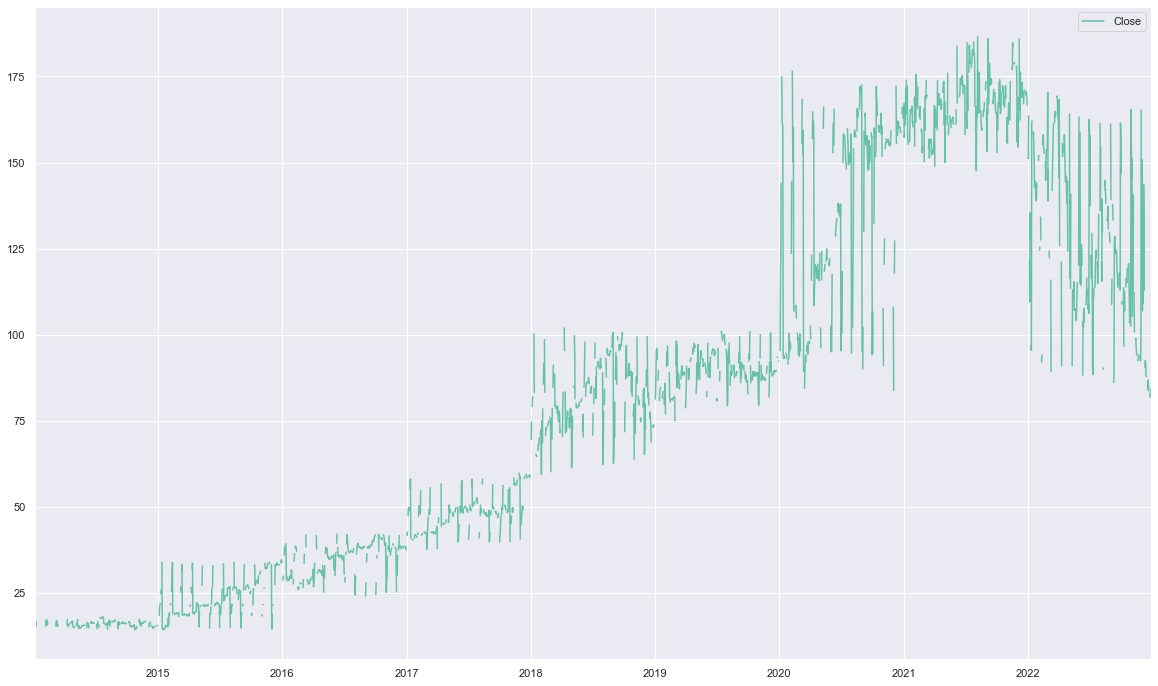

In [19]:
plot = df.head(3619).plot(figsize=(20, 12))

# forward fill

In [20]:
    df["ffilled"] = df["Close"].ffill()
    df.head(12)

,Close,ffilled
2014-01-04,17.149500,17.149500
2014-01-05,15.394500,15.394500
2014-01-06,NaN,15.394500
2014-01-07,16.619499,16.619499
2014-01-08,15.353000,15.353000
2014-01-09,NaN,15.353000
2014-01-10,15.873000,15.873000
2014-01-11,NaN,15.873000
2014-01-12,16.299999,16.299999
2014-01-13,NaN,16.299999


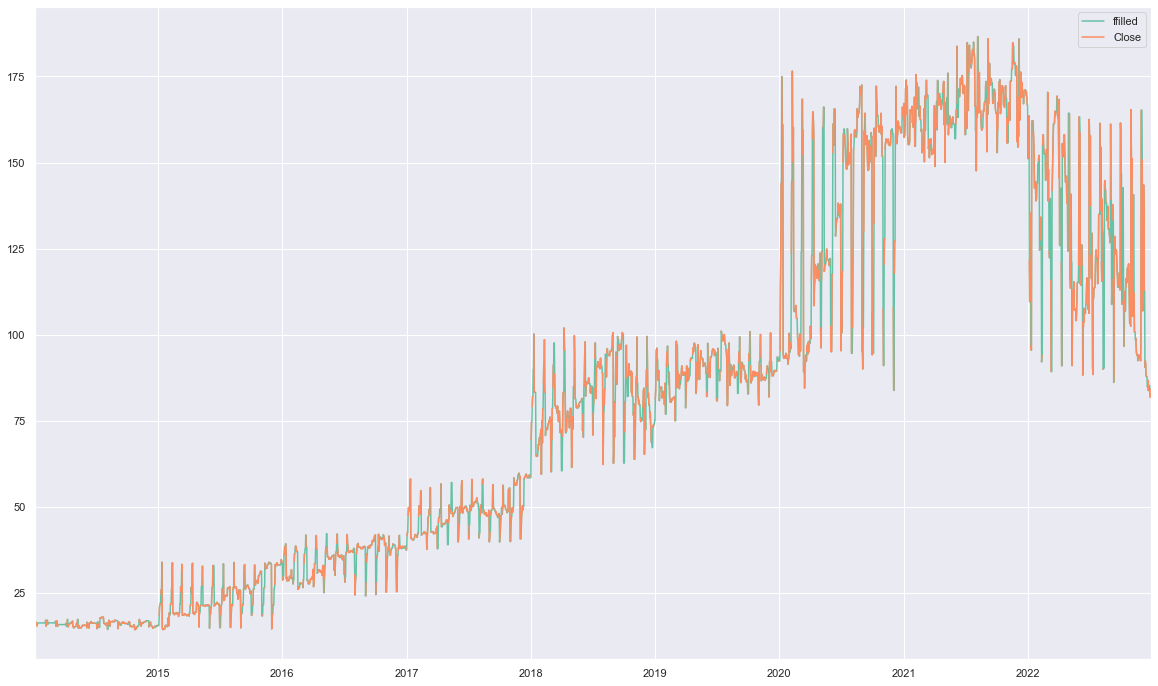

In [21]:
df = df[["ffilled", "Close"]]
plot = df.head(3619).plot(figsize=(20, 12))

In [22]:
df.ffilled

2014-01-04    17.149500
2014-01-05    15.394500
2014-01-06    15.394500
2014-01-07    16.619499
2014-01-08    15.353000
                ...    
2022-12-26    85.250000
2022-12-27    83.040001
2022-12-28    81.820000
2022-12-29    84.180000
2022-12-30    84.000000
Name: ffilled, Length: 3283, dtype: float64

In [23]:
df.rename(columns={"ffilled": "close"}, inplace=True)
df

,close,Close
2014-01-04,17.149500,17.149500
2014-01-05,15.394500,15.394500
2014-01-06,15.394500,NaN
2014-01-07,16.619499,16.619499
2014-01-08,15.353000,15.353000
...,...,...
2022-12-26,85.250000,NaN
2022-12-27,83.040001,83.040001
2022-12-28,81.820000,81.820000
2022-12-29,84.180000,84.180000


In [24]:
df.drop(["Close"],axis=1,inplace=True)

In [25]:
df

,close
2014-01-04,17.149500
2014-01-05,15.394500
2014-01-06,15.394500
2014-01-07,16.619499
2014-01-08,15.353000
...,...
2022-12-26,85.250000
2022-12-27,83.040001
2022-12-28,81.820000
2022-12-29,84.180000


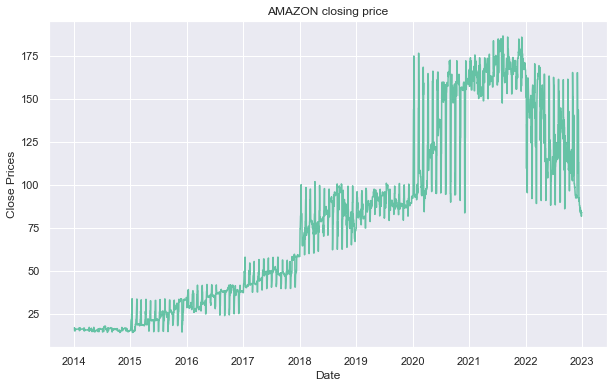

In [26]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['close'])
plt.title('AMAZON closing price')
plt.show()

# Checking stationarity of the data

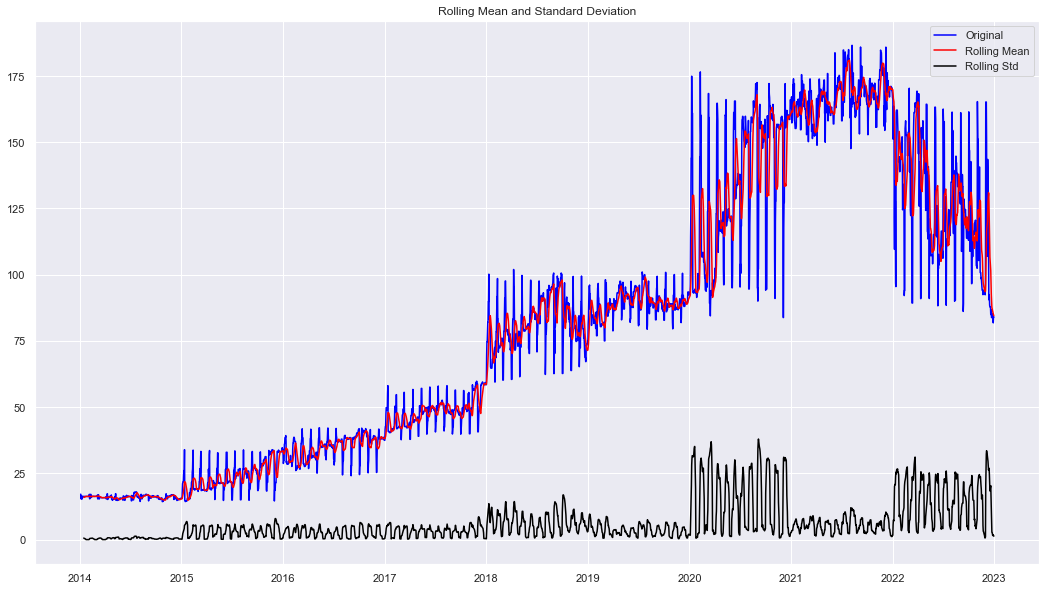

Results of dickey fuller test
Test Statistics                  -1.297927
p-value                           0.630120
No. of lags used                 29.000000
Number of observations used    3253.000000
critical value (1%)              -3.432362
critical value (5%)              -2.862429
critical value (10%)             -2.567243
dtype: float64


In [27]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    plt.figure(figsize=(18, 10))

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df.close)

  ## Differencing

In [28]:
diff_df=df.diff()
diff_df

,close
2014-01-04,NaN
2014-01-05,-1.755000
2014-01-06,0.000000
2014-01-07,1.224999
2014-01-08,-1.266499
...,...
2022-12-26,0.000000
2022-12-27,-2.209999
2022-12-28,-1.220001
2022-12-29,2.360000


# TRAIN TEST SPLIT

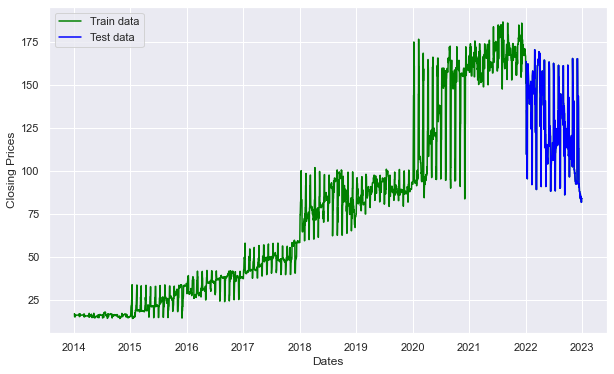

In [29]:
#split data into train and training set
#train_data, test_data = df[3:int(len(df)*0.9)], df[int(len(df)*0.9):]
train_data = df.loc[df.index < '01-04-2022']
test_data = df.loc[df.index >= '01-04-2022']
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

# AUTO ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18837.280, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18835.801, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18835.976, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18835.447, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18837.142, Time=0.93 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.783 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2922
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -9416.723
Date:                Sun, 24 Sep 2023   AIC                          18835.447
Time:                        22:08:22   BIC                          18841.426
Sample:                    01-04-2014   HQIC                         18837.600
                         - 01-03-2022                                  

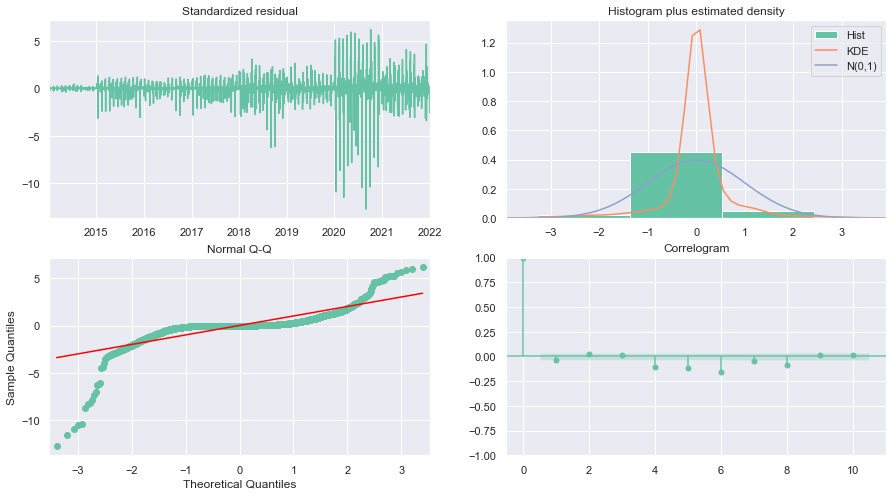

In [30]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

#  Build the model

In [31]:

from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(0,1,0))

fitted=model.fit()

model_summary = fitted.summary()
print(model_summary)

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2922
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -9416.723
Date:                Sun, 24 Sep 2023   AIC                          18835.447
Time:                        22:08:37   BIC                          18841.426
Sample:                    01-04-2014   HQIC                         18837.600
                         - 01-03-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        36.9564      0.207    178.949      0.000      36.552      37.361
Ljung-Box (L1) (Q):                   3.48   Jarque-Bera (JB):            218519.05
Prob(Q):                              0.06   Pr

# Forecasting on test dadaset

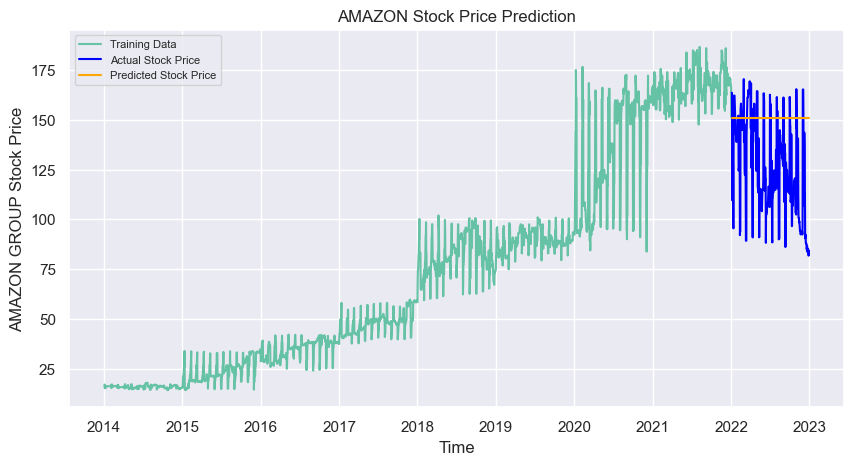

In [36]:
# Forecast
forecast_steps = 361  # Adjust this to your desired number of forecasted time steps
forecast_values = fitted.forecast(steps=forecast_steps)  # Forecast values

# Make as pandas series
fc_series = pd.Series(forecast_values, index=test_data.index)  # Use the appropriate index

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.title('AMAZON Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AMAZON GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

##  Evaluating Forecast results

In [37]:
# report performance
mse = mean_squared_error(test_data, forecast_values)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, forecast_values)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, forecast_values))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(forecast_values - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 1194.506018729031
MAE: 28.56649002770083
RMSE: 34.56162639010252
MAPE: 2022-01-04 00:00:00   NaN
2022-01-05 00:00:00   NaN
2022-01-06 00:00:00   NaN
2022-01-07 00:00:00   NaN
2022-01-08 00:00:00   NaN
                       ..
2022-12-27 00:00:00   NaN
2022-12-28 00:00:00   NaN
2022-12-29 00:00:00   NaN
2022-12-30 00:00:00   NaN
close                 NaN
Length: 362, dtype: float64


In [38]:
def mean_directional_accuracy(actual, forecasted):
    # Calculate the directional changes in actual and forecasted values
    actual_changes = np.sign(np.diff(actual))
    forecasted_changes = np.sign(np.diff(forecasted))
    
    # Calculate MDA by comparing directional changes
    mda = np.mean(actual_changes == forecasted_changes)
    return mda

# Assuming you have test_data and forecast_values
mda = mean_directional_accuracy(test_data, forecast_values)
print('Mean Directional Accuracy (MDA): {:.2%}'.format(mda))

Mean Directional Accuracy (MDA): 0.00%


In [ ]:
                                          Figure 9: XG Boost Forecast on Microsoft Stock